In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, top_k_accuracy_score, ConfusionMatrixDisplay
from pprint import pprint
from joblib import dump, load

In [3]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    my_accuracy = np.mean(predictions == test_labels)
    my_f1_score = f1_score(test_labels, predictions, average='macro')
    prob_predictions = model.predict_proba(test_features)
    my_top_k_accuracy_score = top_k_accuracy_score(test_labels, prob_predictions, k=3)
    
    print('Model Performance')
    print('Accuracy = {:0.4f}'.format(my_accuracy))
    print('F1 Score = {:0.4f}'.format(my_f1_score))
    print('Top 3 Accuracy Score = {:0.4f}'.format(my_top_k_accuracy_score))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(test_labels, predictions, ax=ax)
    
    return my_f1_score

In [4]:
# Split labels and features
df = pd.read_csv('all_weather_data.csv')
labels = df['weather_description'].to_numpy()
features = (df.drop(columns=['weather_description'])).to_numpy()
train_labels, test_labels, train_features, test_features = train_test_split(labels, features, test_size=0.2, random_state=42)

In [4]:
base_model = RandomForestClassifier(random_state = 42)
base_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

Model Performance
Accuracy = 0.4580
F1 Score = 0.4462
Top 3 Accuracy Score = 0.7329


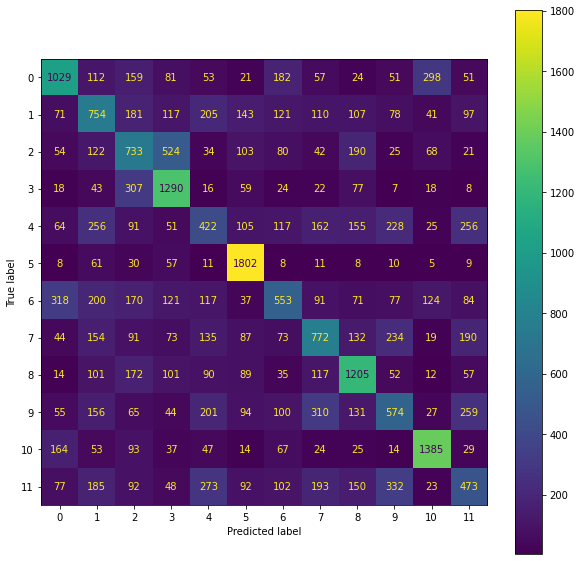

In [5]:
base_accuracy = evaluate(base_model, test_features, test_labels)

In [6]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 6)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 6)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 26, 42, 58, 74, 90, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 280, 460, 640, 820, 1000]}


In [6]:
try:
    # Try restoring the model
    rf_random = load('rf_random.joblib')
    
except:
    # Use the random grid to search for best hyper-parameters
    # First create the base model to tune
    rf = RandomForestClassifier()

    # Random search of parameters, using 3-fold cross validation,
    # search across 10 different combinations, and use 1 core
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = 1)

    # Fit the random search model
    rf_random.fit(train_features, train_labels)
    
    # Save the model
    dump(rf_random, 'rf_random.joblib')

In [4]:
pprint(rf_random_best_params)

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 640}


Model Performance
Accuracy = 0.4652
F1 Score = 0.4547
Top 3 Accuracy Score = 0.7468


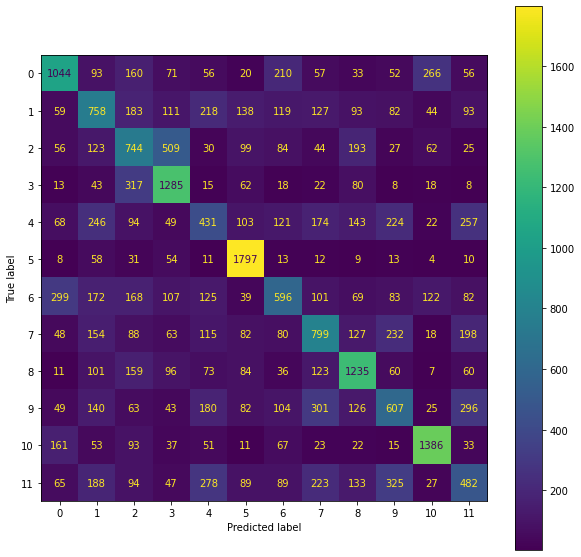

In [7]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

In [8]:
print('Improvement of {:0.4f}% from default RandomForestClassifier parameters.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.9044% from default RandomForestClassifier parameters.


In [5]:
try:
    # Try restoring the model
    grid_search = load('grid_search.joblib') 
    
except:
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [False],
        'max_depth': [None],
        'min_samples_leaf': [1],
        'n_estimators': [640, 470, 300],
        'min_samples_split': [2, 3, 4, 5],
        'max_features': ['log2', 'sqrt']
    }

    # Create a based model
    rf = RandomForestClassifier()

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=1)

    # Fit the grid search to the data
    grid_search.fit(train_features, train_labels)
    
    # Save the model
    dump(grid_search, 'grid_search.joblib')

In [6]:
pprint(grid_search.best_params_)

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 470}


Model Performance
Accuracy = 0.4650
F1 Score = 0.4556
Top 3 Accuracy Score = 0.7435


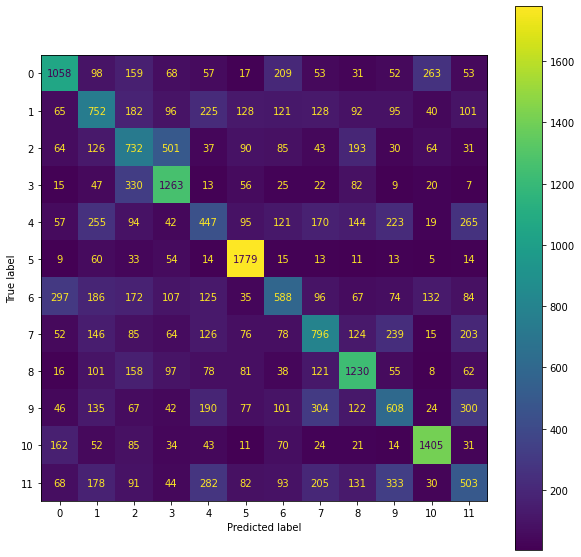

In [6]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [12]:
print('Improvement of {:0.4f}% compared to random parameter search.'.format(100 * (grid_accuracy - random_accuracy) / random_accuracy))

Improvement of 0.2079% compared to random parameter search.


In [7]:
try:
    # Try restoring the model
    grid_search_final = load('grid_search_final.joblib')
    
except:
    # Create the parameter grid based on the results of the first grid search 
    param_grid_final = {
        'bootstrap': [False],
        'max_depth': [None],
        'min_samples_leaf': [1],
        'min_samples_split': [3],
        'max_features': ['log2'],
        'n_estimators': [530, 515, 500, 485, 470, 455, 440, 425, 410]
    }

    # Create a based model
    rf = RandomForestClassifier()

    # Instantiate the grid search model
    grid_search_final = GridSearchCV(estimator=rf, param_grid=param_grid_final, cv=3, verbose=2, n_jobs=1)

    # Fit the grid search to the data
    grid_search_final.fit(train_features, train_labels)
    
    # Save the model
    dump(grid_search_final, 'grid_search_final.joblib')

In [ ]:
pprint(grid_search_final.best_params_)

Model Performance
Accuracy = 0.4654
F1 Score = 0.4555
Top 3 Accuracy Score = 0.7451


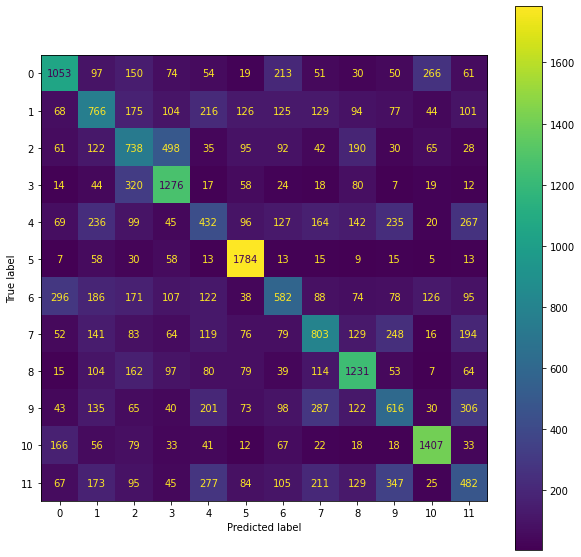

In [8]:
best_grid_final = grid_search_final.best_estimator_
grid_accuracy_final = evaluate(best_grid_final, test_features, test_labels)

In [9]:
print('Improvement of {:0.4f}% compared to first grid parameter search.'.format(100 * (grid_accuracy_final - grid_accuracy) / grid_accuracy))

Improvement of -0.0344% compared to first grid parameter search.
